# Экспериментальная часть задачи

В данном разделе я скомбинировал различные методы, направленные на повышение метрик, по результатам которых я выбрал XGBoost + Class_Weight.  
Не смотря на то, что XGBoost + SMOTE показал немного лучший результат, однако, я больше склонен доверять class weight методу в виду того, что данные в SMOTE генерируются и не гарантируют того,  
что генерализация такого пайплайна останется на приемлимом уровне, текущий набор данных отражает операции всего за 2 дня, репрезентативность такого датасета не может быть на хорошем уровне, поэтому данных шаг является оправданным, даже не смотря на то, что мы немного теряем в метриках. 

Проблемы SMOTE в контексте нашей задачи:

  - Ограниченная репрезентативность данных:

    - Набор данных охватывает всего 2 дня транзакций

    - Не отражает полное разнообразие паттернов мошенничества

    - Генерация синтетических примеров может усиливать sampling bias

  - Риск переобучения:

    - Синтетические данные наследуют шум исходных minority-примеров

    - Искусственное завышение метрик на валидации

    - Снижение способности к генерализации на новых данных

In [ ]:
import shap
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score, precision_score, recall_score, f1_score, roc_auc_score, auc
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [ ]:

df = pd.read_csv('creditcard.csv')
df_processed = df.copy()

df_processed['Log_Amount'] = np.log1p(df_processed['Amount'])
df_processed['Time_sin'] = np.sin(2 * np.pi * df_processed['Time'] / 86400)
df_processed['Time_cos'] = np.cos(2 * np.pi * df_processed['Time'] / 86400)

df_processed['Amount_Time_Interaction'] = df_processed['Log_Amount'] * df_processed['Time_sin']
df_processed['Amount_Scaled'] = (df_processed['Amount'] - df_processed['Amount'].mean()) / df_processed['Amount'].std()

features = [f'V{i}' for i in range(1, 29)] + ['Log_Amount', 'Time_sin', 'Time_cos', 'Amount_Time_Interaction', 'Amount_Scaled']
X = df_processed[features]
y = df_processed['Class']

print(f"Размер данных: {X.shape}")
print(f"Баланс классов: {y.value_counts().to_dict()}")

Размер данных: (284807, 33)
Баланс классов: {0: 284315, 1: 492}


In [20]:
# расширенное разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# расчет весов для дисбаланса
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])
print(f"Коэффициент весов: {scale_pos_weight:.2f}")

Коэффициент весов: 577.29


In [21]:
# расширенный набор моделей и стратегий
models_config = {
    # XGBoost с разными стратегиями
    'XGBoost_Default': {
        'model': xgb.XGBClassifier(random_state=42, eval_metric='logloss', n_estimators=200),
        'strategy': 'default'
    },
    'XGBoost_ClassWeight': {
        'model': xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, eval_metric='logloss', n_estimators=200),
        'strategy': 'class_weight'
    },
    'XGBoost_SMOTE': {
        'model': Pipeline([
            ('smote', SMOTE(random_state=42, sampling_strategy=0.1)),
            ('xgb', xgb.XGBClassifier(random_state=42, eval_metric='logloss', n_estimators=200))
        ]),
        'strategy': 'smote'
    },
    
    # LightGBM
    'LightGBM_ClassWeight': {
        'model': LGBMClassifier(random_state=42, n_estimators=200, scale_pos_weight=scale_pos_weight),
        'strategy': 'class_weight'
    },
    
    # CatBoost
    'CatBoost_Default': {
        'model': CatBoostClassifier(random_state=42, verbose=0, n_estimators=200),
        'strategy': 'default'
    },
    'CatBoost_ClassWeight': {
        'model': CatBoostClassifier(scale_pos_weight=scale_pos_weight, random_state=42, verbose=0, n_estimators=200),
        'strategy': 'class_weight'
    },
    
    # Random Forest
    'RF_ClassWeight': {
        'model': RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced'),
        'strategy': 'class_weight'
    },
    'RF_SMOTEENN': {
        'model': Pipeline([
            ('smoteenn', SMOTEENN(random_state=42)),
            ('rf', RandomForestClassifier(n_estimators=200, random_state=42))
        ]),
        'strategy': 'smoteenn'
    }
}

# ансамбль лучших моделей
ensemble_models = [
    ('xgb_weighted', models_config['XGBoost_ClassWeight']['model']),
    ('lgbm_weighted', models_config['LightGBM_ClassWeight']['model']),
    ('catboost_weighted', models_config['CatBoost_ClassWeight']['model'])
]

models_config['Ensemble_Voting'] = {
    'model': VotingClassifier(estimators=ensemble_models, voting='soft'),
    'strategy': 'ensemble'
}

In [ ]:
def evaluate_model(model, X_test, y_test, y_pred_proba):
    """Расширенная оценка модели с multiple метриками"""
    
    y_pred = (y_pred_proba >= 0.5).astype(int)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall_vals, precision_vals)
    
    f1_scores = []
    thresholds = np.linspace(0, 1, 100)
    for threshold in thresholds:
        y_pred_thresh = (y_pred_proba >= threshold).astype(int)
        f1_scores.append(f1_score(y_test, y_pred_thresh))
    
    optimal_threshold = thresholds[np.argmax(f1_scores)]
    optimal_f1 = np.max(f1_scores)
    
    return {
        'precision': precision,
        'recall': recall, 
        'f1': f1,
        'roc_auc': roc_auc,
        'avg_precision': avg_precision,
        'pr_auc': pr_auc,
        'optimal_threshold': optimal_threshold,
        'optimal_f1': optimal_f1,
        'y_pred_proba': y_pred_proba
    }

In [23]:
# обучение и оценка всех моделей
results = {}
detailed_metrics = []

print("Обучение моделей...")

for name, config in models_config.items():
    print(f"Обучение: {name}")
    
    model = config['model']
    model.fit(X_train, y_train)
    
    # получение вероятностей
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = model.named_steps[list(model.named_steps.keys())[-1]].predict_proba(X_test)[:, 1]
    
    # расширенная оценка
    metrics = evaluate_model(model, X_test, y_test, y_pred_proba)
    
    results[name] = {
        'model': model,
        'y_pred_proba': y_pred_proba,
        'strategy': config['strategy'],
        **metrics
    }
    
    detailed_metrics.append({
        'Model': name,
        'Strategy': config['strategy'],
        **{k: v for k, v in metrics.items() if k not in ['y_pred_proba', 'optimal_threshold']}
    })

# создание сравнительной таблицы
comparison_df = pd.DataFrame(detailed_metrics)
comparison_df = comparison_df.sort_values('f1', ascending=False)

Обучение моделей...
Обучение: XGBoost_Default
Обучение: XGBoost_ClassWeight
Обучение: XGBoost_SMOTE
Обучение: LightGBM_ClassWeight
[LightGBM] [Info] Number of positive: 394, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8415
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001729 -> initscore=-6.358339
[LightGBM] [Info] Start training from score -6.358339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


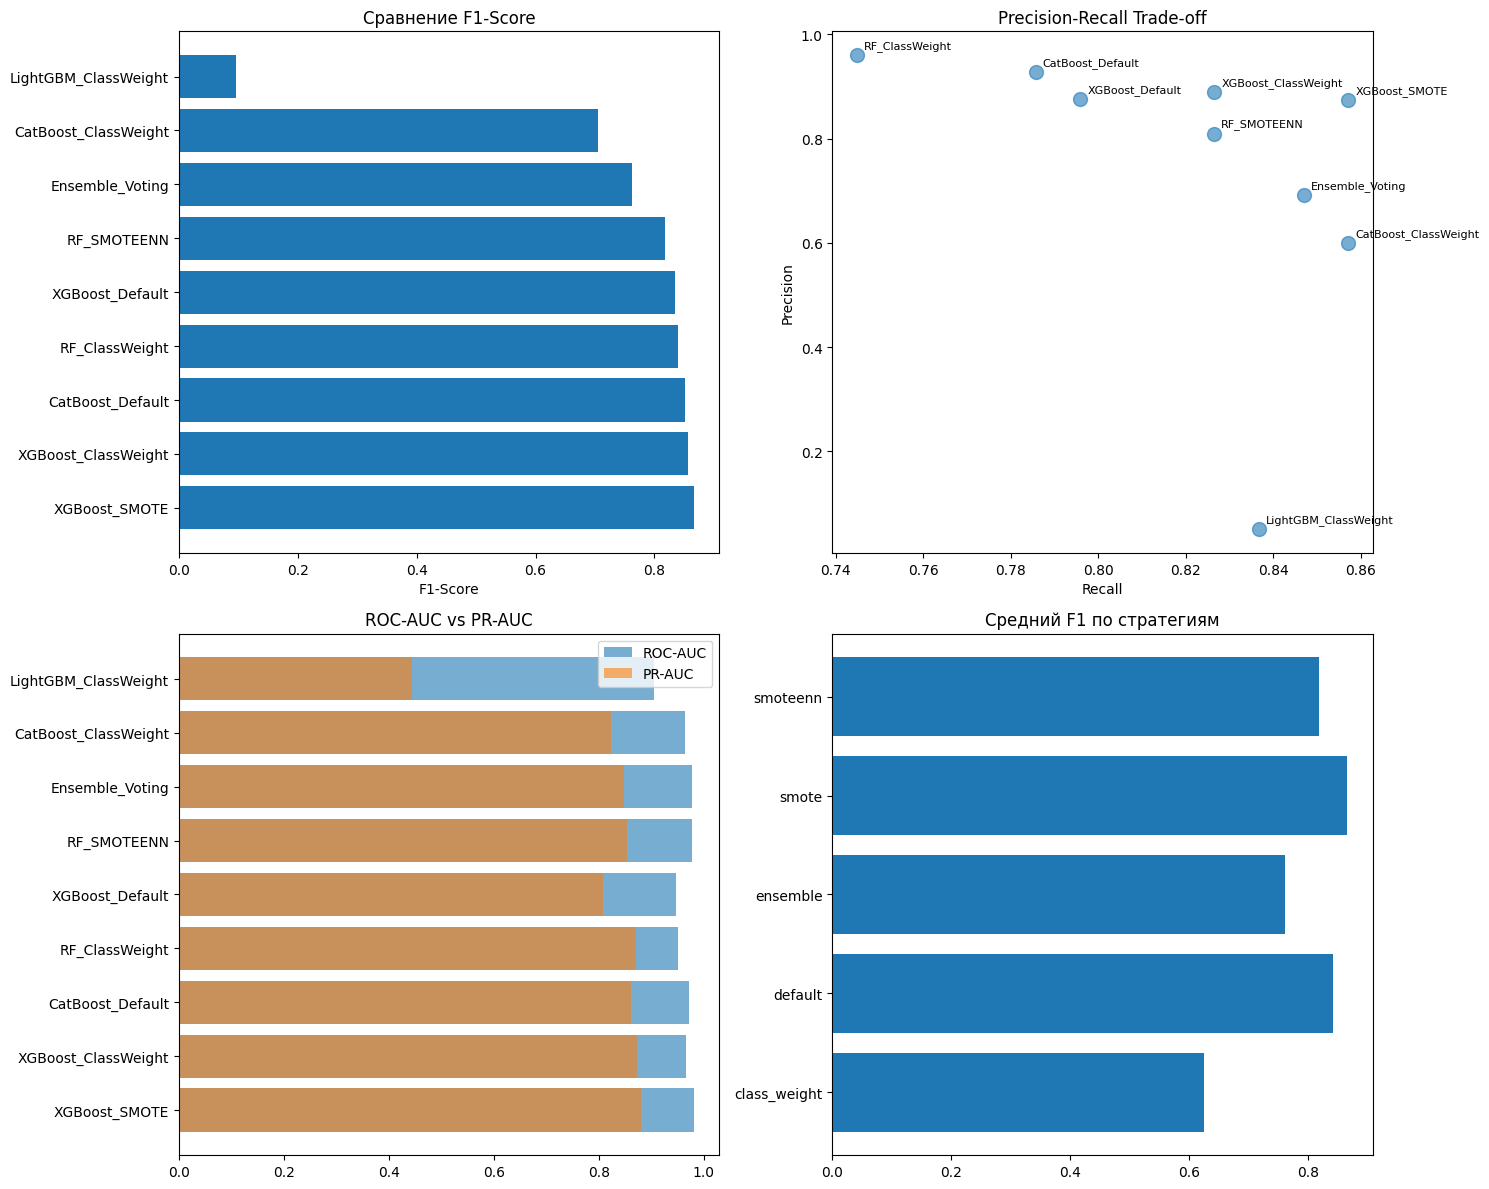

In [24]:
# визуализация сравнения моделей
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# F1-Score сравнение
axes[0,0].barh(comparison_df['Model'], comparison_df['f1'])
axes[0,0].set_title('Сравнение F1-Score')
axes[0,0].set_xlabel('F1-Score')

# Precision-Recall сравнение  
axes[0,1].scatter(comparison_df['recall'], comparison_df['precision'], s=100, alpha=0.6)
for i, row in comparison_df.iterrows():
    axes[0,1].annotate(row['Model'], (row['recall'], row['precision']), xytext=(5, 5), 
                      textcoords='offset points', fontsize=8)
axes[0,1].set_xlabel('Recall')
axes[0,1].set_ylabel('Precision')
axes[0,1].set_title('Precision-Recall Trade-off')

# ROC-AUC vs PR-AUC
axes[1,0].barh(np.arange(len(comparison_df)), comparison_df['roc_auc'], alpha=0.6, label='ROC-AUC')
axes[1,0].barh(np.arange(len(comparison_df)), comparison_df['pr_auc'], alpha=0.6, label='PR-AUC')
axes[1,0].set_yticks(np.arange(len(comparison_df)))
axes[1,0].set_yticklabels(comparison_df['Model'])
axes[1,0].set_title('ROC-AUC vs PR-AUC')
axes[1,0].legend()

# Метрики по стратегиям
strategy_metrics = comparison_df.groupby('Strategy')[['f1', 'roc_auc', 'pr_auc']].mean()
axes[1,1].barh(np.arange(len(strategy_metrics)), strategy_metrics['f1'])
axes[1,1].set_yticks(np.arange(len(strategy_metrics)))
axes[1,1].set_yticklabels(strategy_metrics.index)
axes[1,1].set_title('Средний F1 по стратегиям')

plt.tight_layout()
plt.show()

In [25]:
# вывод результатов
print("Результаты экспериментов:")
print("="*80)
display_cols = ['Model', 'Strategy', 'f1', 'precision', 'recall', 'roc_auc', 'pr_auc']
print(comparison_df[display_cols].round(4).to_string(index=False))

# анализ лучшей модели
best_model_name = comparison_df.iloc[0]['Model']
best_model_result = results[best_model_name]
print(f"\nЛучшая модель: {best_model_name}")
print(f"F1-Score: {best_model_result['f1']:.4f}")
print(f"Optimal threshold: {best_model_result['optimal_threshold']:.4f}")

Результаты экспериментов:
               Model     Strategy     f1  precision  recall  roc_auc  pr_auc
       XGBoost_SMOTE        smote 0.8660     0.8750  0.8571   0.9810  0.8814
 XGBoost_ClassWeight class_weight 0.8571     0.8901  0.8265   0.9665  0.8733
    CatBoost_Default      default 0.8508     0.9277  0.7857   0.9714  0.8618
      RF_ClassWeight class_weight 0.8391     0.9605  0.7449   0.9520  0.8715
     XGBoost_Default      default 0.8342     0.8764  0.7959   0.9466  0.8076
         RF_SMOTEENN     smoteenn 0.8182     0.8100  0.8265   0.9776  0.8538
     Ensemble_Voting     ensemble 0.7615     0.6917  0.8469   0.9773  0.8484
CatBoost_ClassWeight class_weight 0.7059     0.6000  0.8571   0.9640  0.8227
LightGBM_ClassWeight class_weight 0.0957     0.0508  0.8367   0.9049  0.4439

Лучшая модель: XGBoost_SMOTE
F1-Score: 0.8660
Optimal threshold: 0.9697


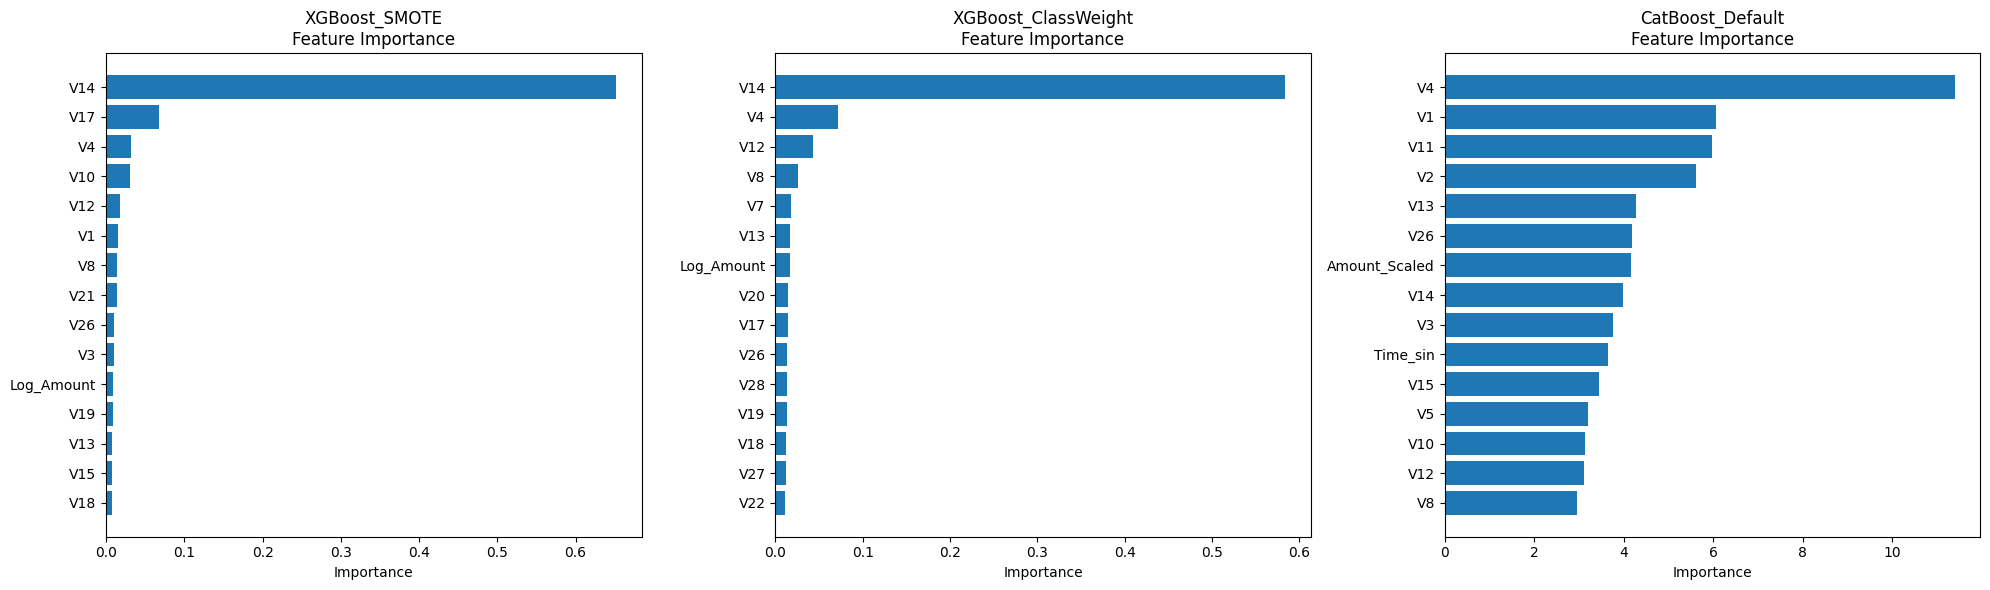

In [26]:
# анализ важности признаков для лучших моделей
top_models = comparison_df.head(3)['Model'].tolist()

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, model_name in enumerate(top_models):
    model_data = results[model_name]
    model = model_data['model']
    
    # получение основной модели из pipeline если нужно
    if hasattr(model, 'named_steps'):
        model = model.named_steps[list(model.named_steps.keys())[-1]]
    
    if hasattr(model, 'feature_importances_'):
        importance_df = pd.DataFrame({
            'feature': features,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=True).tail(15)
        
        axes[i].barh(importance_df['feature'], importance_df['importance'])
        axes[i].set_title(f'{model_name}\nFeature Importance')
        axes[i].set_xlabel('Importance')

plt.tight_layout()
plt.show()

SHAP анализ для лучшей модели...


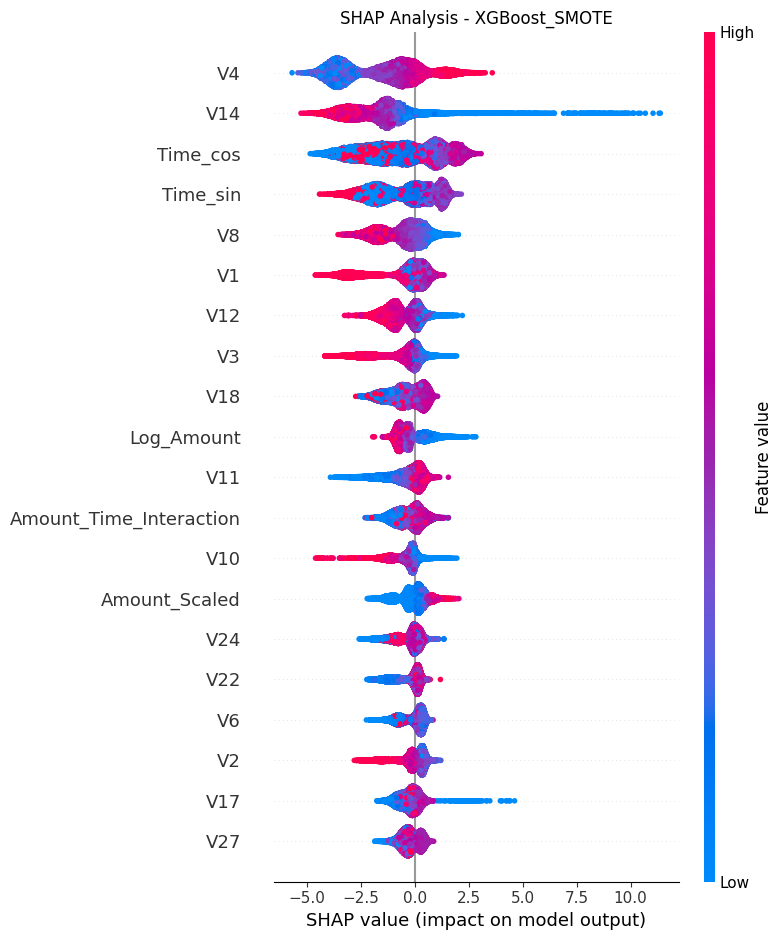

SHAP force plots для нескольких примеров...


<Figure size 1400x500 with 0 Axes>

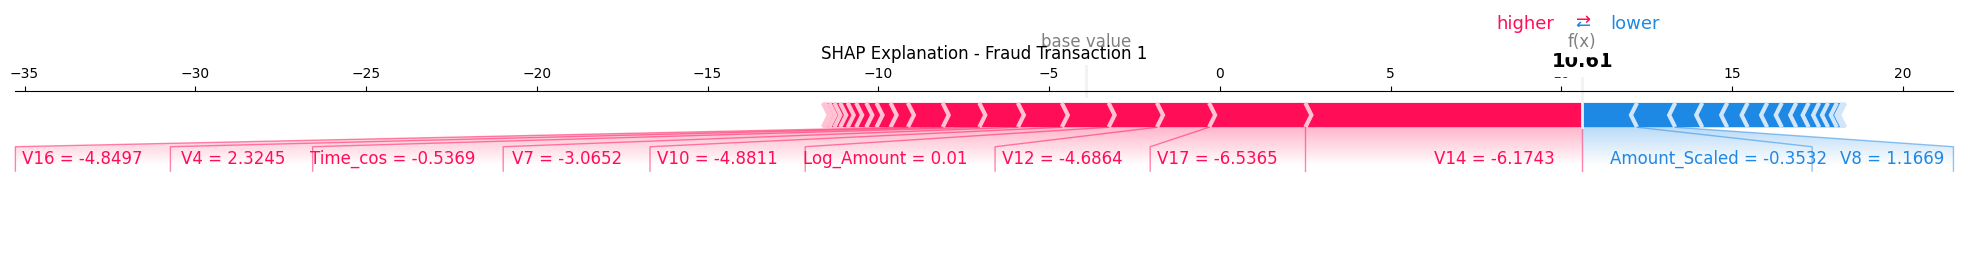

Транзакция 1:
  Вероятность фрода: 1.0000
  Предсказанный класс: Fraud
  Фактический класс: Fraud
  Оригинальный индекс: 77348
  Топ-3 влиятельных признака:
    1. V14: -6.1743 (увеличивает вероятность на 8.1096)
    2. V17: -6.5365 (увеличивает вероятность на 2.8188)
    3. Amount_Scaled: -0.3532 (уменьшает вероятность на 1.6035)



<Figure size 1400x500 with 0 Axes>

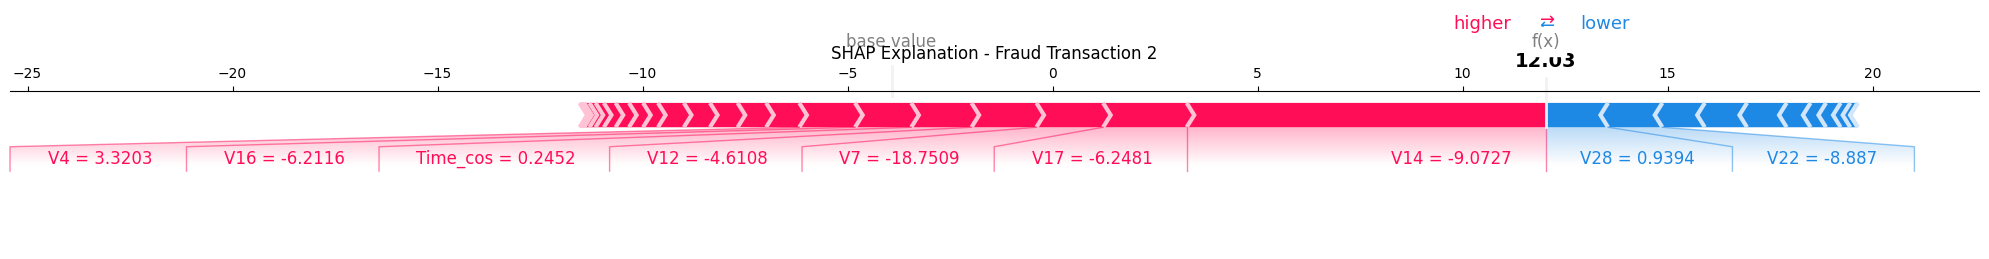

Транзакция 2:
  Вероятность фрода: 1.0000
  Предсказанный класс: Fraud
  Фактический класс: Fraud
  Оригинальный индекс: 102442
  Топ-3 влиятельных признака:
    1. V14: -9.0727 (увеличивает вероятность на 8.7619)
    2. V17: -6.2481 (увеличивает вероятность на 2.0380)
    3. V7: -18.7509 (увеличивает вероятность на 1.6265)



In [ ]:
best_model_data = results[best_model_name]
best_model = best_model_data['model']

if hasattr(best_model, 'named_steps'):
    best_model = best_model.named_steps[list(best_model.named_steps.keys())[-1]]

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, feature_names=features, show=False)
plt.title(f'SHAP Analysis - {best_model_name}')
plt.tight_layout()
plt.show()

fraud_mask = y_test == 1
fraud_indices_positions = np.where(fraud_mask)[0][:2] 

for i, pos_idx in enumerate(fraud_indices_positions):
    plt.figure(figsize=(14, 5)) 
    feature_values_rounded = np.round(X_test.iloc[pos_idx].values, 4)
    shap_values_rounded = np.round(shap_values[pos_idx], 4)
    base_value_rounded = np.round(explainer.expected_value, 4)
    
    shap.force_plot(
        base_value_rounded, 
        shap_values_rounded, 
        feature_values_rounded,
        feature_names=features, 
        matplotlib=True, 
        show=False
    )
    plt.title(f'SHAP Explanation - Fraud Transaction {i+1}')
    plt.tight_layout()
    plt.show()
    
    original_idx = X_test.index[pos_idx]
    probability = best_model_data['y_pred_proba'][pos_idx]
    
    print(f"Транзакция {i+1}:")
    print(f"  Вероятность фрода: {probability:.4f}")
    print(f"  Предсказанный класс: {'Fraud' if probability >= 0.5 else 'Normal'}")
    print(f"  Фактический класс: {'Fraud' if y_test.iloc[pos_idx] == 1 else 'Normal'}")
    print(f"  Оригинальный индекс: {original_idx}")
    
    top_features_idx = np.argsort(np.abs(shap_values_rounded))[-3:][::-1]
    print("  Топ-3 влиятельных признака:")
    for j, feat_idx in enumerate(top_features_idx):
        feat_name = features[feat_idx]
        feat_value = feature_values_rounded[feat_idx]
        shap_val = shap_values_rounded[feat_idx]
        direction = "увеличивает" if shap_val > 0 else "уменьшает"
        print(f"    {j+1}. {feat_name}: {feat_value:.4f} ({direction} вероятность на {abs(shap_val):.4f})")
    print()

Проанализируем вадность признаков с помощью Permutation Importance

Permutation Importance анализ...


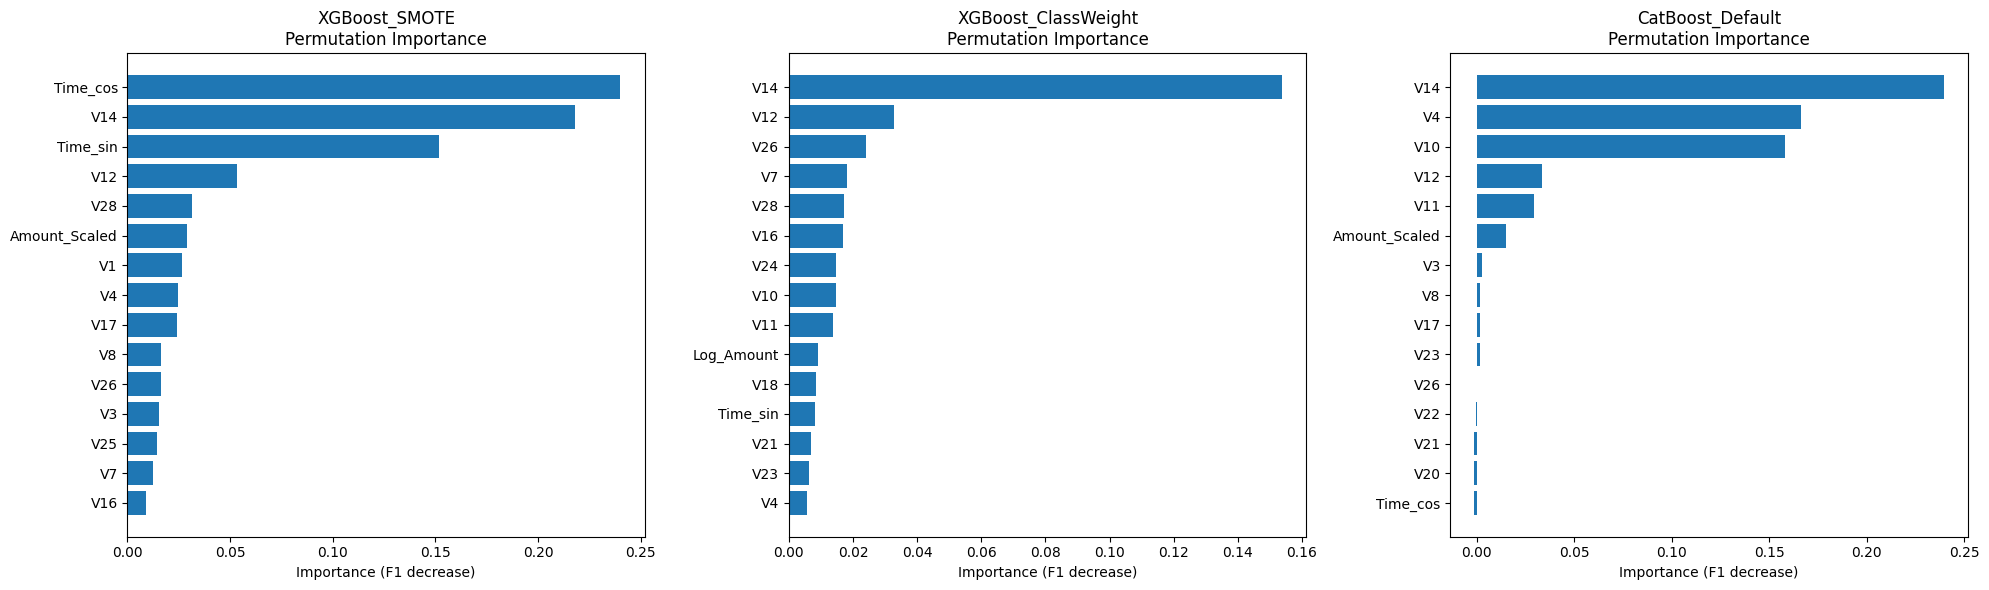

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, model_name in enumerate(top_models):
    model_data = results[model_name]
    model = model_data['model']
    
    # permutation importance
    perm_result = permutation_importance(
        model, X_test, y_test,
        n_repeats=10,
        random_state=42,
        scoring='f1'
    )
    
    perm_df = pd.DataFrame({
        'feature': features,
        'importance': perm_result.importances_mean
    }).sort_values('importance', ascending=True).tail(15)
    
    axes[i].barh(perm_df['feature'], perm_df['importance'])
    axes[i].set_title(f'{model_name}\nPermutation Importance')
    axes[i].set_xlabel('Importance (F1 decrease)')

plt.tight_layout()
plt.show()

Кросс-валидация лучших моделей...


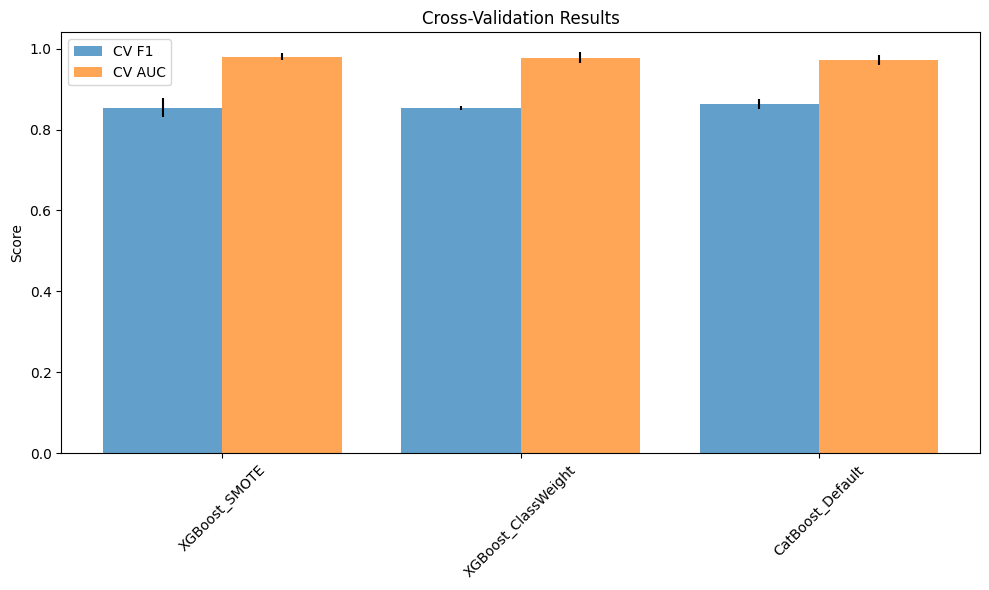

CV результаты:
                     cv_f1_mean  cv_f1_std  cv_auc_mean  cv_auc_std
XGBoost_SMOTE            0.8540     0.0238       0.9801      0.0088
XGBoost_ClassWeight      0.8528     0.0052       0.9774      0.0133
CatBoost_Default         0.8625     0.0121       0.9714      0.0116


In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

for model_name in top_models:
    model = results[model_name]['model']
    
    # cv scores
    cv_f1 = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1)
    cv_auc = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    
    cv_results[model_name] = {
        'cv_f1_mean': cv_f1.mean(),
        'cv_f1_std': cv_f1.std(),
        'cv_auc_mean': cv_auc.mean(),
        'cv_auc_std': cv_auc.std()
    }

cv_df = pd.DataFrame(cv_results).T
plt.figure(figsize=(10, 6))
x_pos = np.arange(len(cv_df))
plt.bar(x_pos - 0.2, cv_df['cv_f1_mean'], 0.4, label='CV F1', alpha=0.7, yerr=cv_df['cv_f1_std'])
plt.bar(x_pos + 0.2, cv_df['cv_auc_mean'], 0.4, label='CV AUC', alpha=0.7, yerr=cv_df['cv_auc_std'])
plt.xticks(x_pos, cv_df.index, rotation=45)
plt.ylabel('Score')
plt.title('Cross-Validation Results')
plt.legend()
plt.tight_layout()
plt.show()

print("CV результаты:")
print(cv_df.round(4))